In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [4]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)
df = df.drop_duplicates()

# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

number of duplicate rows:  (3854, 9)


In [5]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 2 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [6]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [7]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [8]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [9]:
df = df.drop("HbA1c_level", axis = 1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,140,0
1,Female,54.00,0,0,No Info,27.32,80,0
2,Male,28.00,0,0,never,27.32,158,0
3,Female,36.00,0,0,current,23.45,155,0
4,Male,76.00,1,1,current,20.14,155,0


In [10]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 1
    elif smoking_status == 'current':
        return 2
    elif smoking_status in ['ever', 'former', 'not current']:
        return 3

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

1    67276
3    19655
2     9197
Name: smoking_history, dtype: int64


In [11]:
# Define a function to map the existing categories to new ones
def recategorize_gender(gender_status):
    if gender_status == 'Male':
        return 1
    elif gender_status == 'Female':
        return 0

# Apply the function to the 'smoking_history' column
df['gender'] = df['gender'].apply(recategorize_gender)

# Check the new value counts
print(df['gender'].value_counts())

0    56161
1    39967
Name: gender, dtype: int64


In [12]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df["blood_glucose_level"]
df["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df = df.drop("blood_glucose_level", axis=1)
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes,voltage_ratio
0,0,80.00,0,1,1,25.19,0,56.24
1,0,54.00,0,0,1,27.32,0,72.80
2,1,28.00,0,0,1,27.32,0,51.27
3,0,36.00,0,0,2,23.45,0,52.10
4,1,76.00,1,1,2,20.14,0,52.10


In [13]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'voltage_ratio', 'diabetes']]

print(df)

       gender   age  hypertension  heart_disease  smoking_history   bmi  \
0           0 80.00             0              1                1 25.19   
1           0 54.00             0              0                1 27.32   
2           1 28.00             0              0                1 27.32   
3           0 36.00             0              0                2 23.45   
4           1 76.00             1              1                2 20.14   
...       ...   ...           ...            ...              ...   ...   
99994       0 36.00             0              0                1 24.60   
99996       0  2.00             0              0                1 17.37   
99997       1 66.00             0              0                3 27.83   
99998       0 24.00             0              0                1 35.42   
99999       0 57.00             0              0                2 22.43   

       voltage_ratio  diabetes  
0              56.24         0  
1              72.80         0  


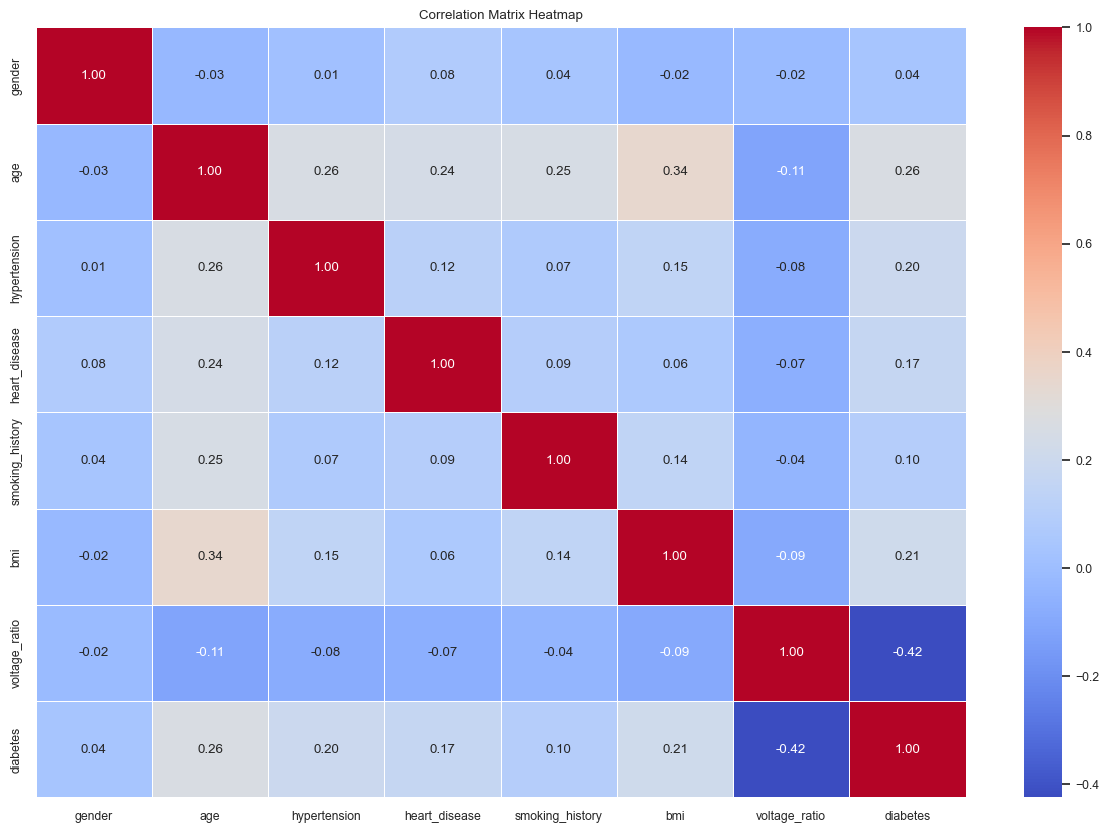

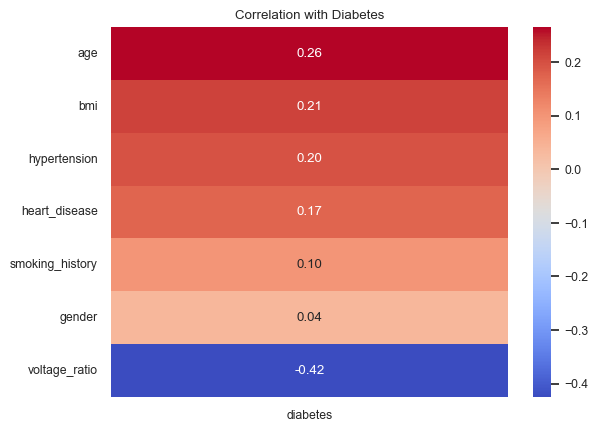

In [27]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')

plt.show()

In [28]:
df_new = df.copy()

In [29]:
# Split data into features and target variable
X = df_new[['voltage_ratio', 'bmi', 'age']]
y = df_new['diabetes']

In [30]:
# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.9)

In [31]:
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [33]:
diabetes_1 = len(y[y == 1])  # Filter for rows where any value is 1
diabetes_0 = len(y[y == 0]) # Filter for rows where any value is 0
print(diabetes_0)
print(diabetes_1)

19476
17529


In [34]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)


In [35]:
model = RandomForestClassifier(criterion='gini',max_features='sqrt', max_leaf_nodes=None)

result = model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Predict on the test set with the best model
y_pred = model.predict(X_test)
print('Training accuracy:', train_accuracy)
print("Model Accuracy : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.973787326037022
Model Accuracy :  0.8511012025401973
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3873
           1       0.85      0.84      0.84      3528

    accuracy                           0.85      7401
   macro avg       0.85      0.85      0.85      7401
weighted avg       0.85      0.85      0.85      7401



         Feature  Importance
0  voltage_ratio        0.40
2            age        0.30
1            bmi        0.30


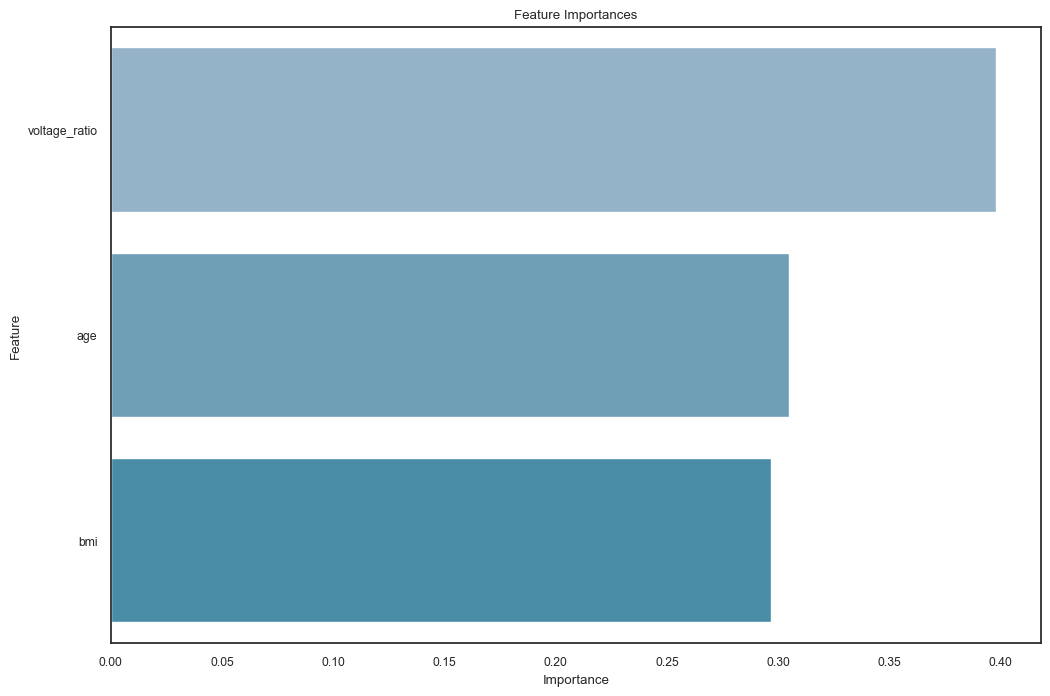

In [36]:
# Then we add the numeric feature names
feature_names = list(df_new[['voltage_ratio', 'bmi', 'age']])
# And now let's get the feature importances
importances = model.feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [37]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.9218348871774085
Model Accuracy:  0.857451695716795
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3859
           1       0.84      0.87      0.85      3542

    accuracy                           0.86      7401
   macro avg       0.86      0.86      0.86      7401
weighted avg       0.86      0.86      0.86      7401



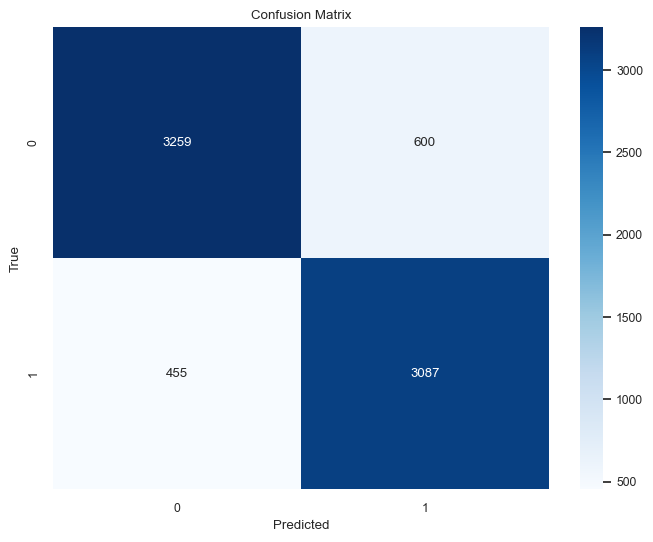

In [38]:
# Create Grid Search object
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

precision:  0.8372660699755899
recall:  0.8715415019762845


         Feature  Importance
0  voltage_ratio        0.45
2            age        0.33
1            bmi        0.22


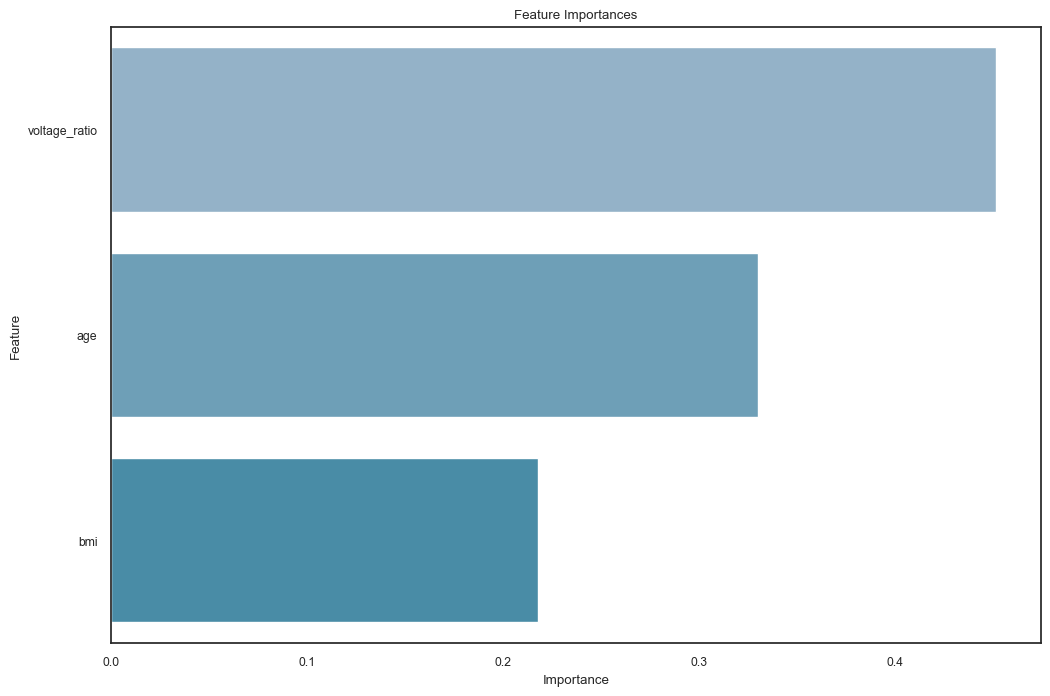

In [40]:
# Then we add the numeric feature names
feature_names = list(df_new[['voltage_ratio', 'bmi', 'age']])

# And now let's get the feature importances
importances = grid_search.best_estimator_.feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

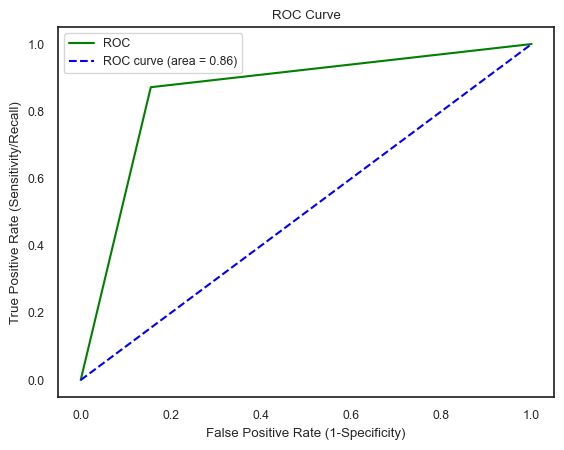

In [41]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

**VALIDATION**

In [42]:
dn = pd.read_csv('diabetes.csv')
dn.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [43]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = dn["Glucose"]
dn["voltage_ratio"] = -0.276*glucose_level_column + 94.882
dn = dn.drop("Glucose", axis=1)
dn.head(5)

,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,voltage_ratio
0,6,72,35,0,33.60,0.63,50,1,54.03
1,1,66,29,0,26.60,0.35,31,0,71.42
2,8,64,0,0,23.30,0.67,32,1,44.37
3,1,66,23,94,28.10,0.17,21,0,70.32
4,0,40,35,168,43.10,2.29,33,1,57.07


In [44]:
dn = dn.rename(columns = {'Age':'age','BMI':'bmi','Outcome' : 'diabetes'})
dn.head()

,Pregnancies,BloodPressure,SkinThickness,Insulin,bmi,DiabetesPedigreeFunction,age,diabetes,voltage_ratio
0,6,72,35,0,33.60,0.63,50,1,54.03
1,1,66,29,0,26.60,0.35,31,0,71.42
2,8,64,0,0,23.30,0.67,32,1,44.37
3,1,66,23,94,28.10,0.17,21,0,70.32
4,0,40,35,168,43.10,2.29,33,1,57.07


In [45]:
dn = dn[['age' ,'bmi', 'voltage_ratio', 'diabetes']]

print(dn)

     age   bmi  voltage_ratio  diabetes
0     50 33.60          54.03         1
1     31 26.60          71.42         0
2     32 23.30          44.37         1
3     21 28.10          70.32         0
4     33 43.10          57.07         1
..   ...   ...            ...       ...
763   63 32.90          67.01         0
764   27 36.80          61.21         0
765   30 26.20          61.49         0
766   47 30.10          60.11         1
767   23 30.40          69.21         0

[768 rows x 4 columns]


In [46]:
X_val = dn[['voltage_ratio', 'bmi', 'age']]
y_val = dn['diabetes']

In [47]:
X_val

,voltage_ratio,bmi,age
0,54.03,33.60,50
1,71.42,26.60,31
2,44.37,23.30,32
3,70.32,28.10,21
4,57.07,43.10,33
...,...,...,...
763,67.01,32.90,63
764,61.21,36.80,27
765,61.49,26.20,30
766,60.11,30.10,47


In [48]:
y_val

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: diabetes, Length: 768, dtype: int64

In [50]:
# Predict on the test set using the best model
validation = grid_search.predict(X_val)

cm = confusion_matrix(y_val, validation)

# Evaluate the model
print("Validation Accuracy: ", accuracy_score(y_val, validation))
print(classification_report(y_val, validation))

Validation Accuracy:  0.6796875
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       500
           1       0.65      0.18      0.28       268

    accuracy                           0.68       768
   macro avg       0.67      0.56      0.54       768
weighted avg       0.67      0.68      0.61       768



In [58]:
df_val = pd.read_csv('Type2Diabetes.csv')
df_val.head()

,Patient number,Cholesterol,Glucose,HDL Chol,Chol/HDL ratio,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Waist/hip ratio,Diabetes,Unnamed: 16,Unnamed: 17
0,1,193,77,49,3.90,19,female,61,119,22.50,118,70,32,38,0.84,No diabetes,6.00,6.00
1,2,146,79,41,3.60,19,female,60,135,26.40,108,58,33,40,0.83,No diabetes,NaN,NaN
2,3,217,75,54,4.00,20,female,67,187,29.30,110,72,40,45,0.89,No diabetes,NaN,NaN
3,4,226,97,70,3.20,20,female,64,114,19.60,122,64,31,39,0.79,No diabetes,NaN,NaN
4,5,164,91,67,2.40,20,female,70,141,20.20,122,86,32,39,0.82,No diabetes,NaN,NaN


In [59]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df_val["Glucose"]
df_val["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df_val = df_val.drop("Glucose", axis=1)
df_val.head(5)

,Patient number,Cholesterol,HDL Chol,Chol/HDL ratio,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Waist/hip ratio,Diabetes,Unnamed: 16,Unnamed: 17,voltage_ratio
0,1,193,49,3.90,19,female,61,119,22.50,118,70,32,38,0.84,No diabetes,6.00,6.00,73.63
1,2,146,41,3.60,19,female,60,135,26.40,108,58,33,40,0.83,No diabetes,NaN,NaN,73.08
2,3,217,54,4.00,20,female,67,187,29.30,110,72,40,45,0.89,No diabetes,NaN,NaN,74.18
3,4,226,70,3.20,20,female,64,114,19.60,122,64,31,39,0.79,No diabetes,NaN,NaN,68.11
4,5,164,67,2.40,20,female,70,141,20.20,122,86,32,39,0.82,No diabetes,NaN,NaN,69.77


In [60]:
df_val = df_val.rename(columns = {'Age':'age','BMI':'bmi','Diabetes' : 'diabetes'})
df_val.head()

,Patient number,Cholesterol,HDL Chol,Chol/HDL ratio,age,Gender,Height,Weight,bmi,Systolic BP,Diastolic BP,waist,hip,Waist/hip ratio,diabetes,Unnamed: 16,Unnamed: 17,voltage_ratio
0,1,193,49,3.90,19,female,61,119,22.50,118,70,32,38,0.84,No diabetes,6.00,6.00,73.63
1,2,146,41,3.60,19,female,60,135,26.40,108,58,33,40,0.83,No diabetes,NaN,NaN,73.08
2,3,217,54,4.00,20,female,67,187,29.30,110,72,40,45,0.89,No diabetes,NaN,NaN,74.18
3,4,226,70,3.20,20,female,64,114,19.60,122,64,31,39,0.79,No diabetes,NaN,NaN,68.11
4,5,164,67,2.40,20,female,70,141,20.20,122,86,32,39,0.82,No diabetes,NaN,NaN,69.77


In [61]:
df_val = df_val[['age' ,'bmi', 'voltage_ratio', 'diabetes']]

print(df_val)

     age   bmi  voltage_ratio     diabetes
0     19 22.50          73.63  No diabetes
1     19 26.40          73.08  No diabetes
2     20 29.30          74.18  No diabetes
3     20 19.60          68.11  No diabetes
4     20 20.20          69.77  No diabetes
..   ...   ...            ...          ...
385   83 25.20          65.90  No diabetes
386   84 37.50          17.88     Diabetes
387   89 21.70          70.04  No diabetes
388   91 24.00          44.10     Diabetes
389   92 39.70          68.94  No diabetes

[390 rows x 4 columns]


In [62]:
# Define a function to map the existing categories to new ones
def recategorize_diabetes(diabetes):
    if diabetes == 'Diabetes':
        return 1
    elif diabetes == 'No diabetes':
        return 0

# Apply the function to the 'smoking_history' column
df_val['diabetes'] = df_val['diabetes'].apply(recategorize_diabetes)

# Check the new value counts
print(df_val['diabetes'].value_counts())

0    330
1     60
Name: diabetes, dtype: int64


In [63]:
X_val1 = df_val[['voltage_ratio', 'bmi', 'age']]
y_val1 = df_val['diabetes']

In [65]:
# Predict on the test set using the best model
validation = grid_search.predict(X_val1)

cm = confusion_matrix(y_val1, validation)

# Evaluate the model
print("Validation Accuracy: ", accuracy_score(y_val1, validation))
print(classification_report(y_val1, validation))

Validation Accuracy:  0.9051282051282051
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       330
           1       0.73      0.62      0.67        60

    accuracy                           0.91       390
   macro avg       0.83      0.79      0.81       390
weighted avg       0.90      0.91      0.90       390

